<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [4]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [5]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [6]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
64504,2015-08-17 22:45:00,0.085938,0.000000,0.089844,0.265625,1.937500
64505,2015-08-17 23:00:00,0.128906,0.000000,0.140625,0.265625,1.750000
64506,2015-08-17 23:15:00,0.082031,0.000000,0.093750,0.265625,1.843750
64507,2015-08-17 23:30:00,0.144531,0.000000,0.156250,0.265625,1.687500


<h4>将一二层数据相加</h4>

In [7]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [8]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [9]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [10]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [11]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [12]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-17 19:00:00,8.187500,1.015625,1.187500,10.390625
2015-08-17 20:00:00,8.031250,1.000000,0.937500,9.968750
2015-08-17 21:00:00,8.656250,1.007812,1.046875,10.710938
2015-08-17 22:00:00,7.468750,0.949219,1.156250,9.574219


<AxesSubplot:>

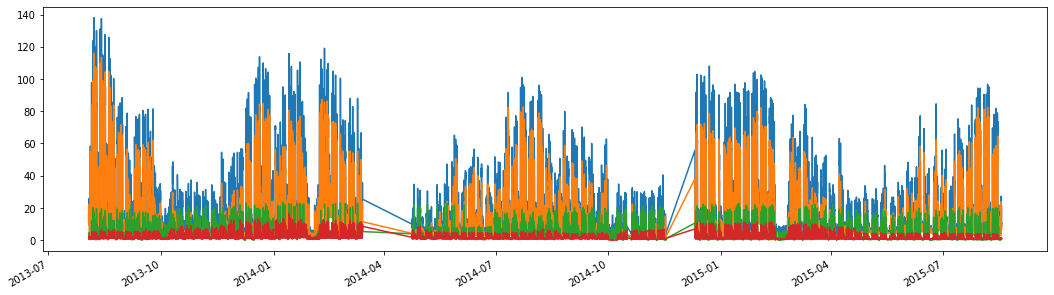

In [13]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [14]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [15]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [16]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["date"] = list(map(lambda x: x.date(), data.index.to_list()))
data["wind_angle"] = data["wind_angle"].apply(lambda x: np.cos(np.pi / 180 * x))
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)

mean_weather = data[["date", "temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]].groupby("date").mean()
sum_weather = data[["date", "rainfall"]].groupby("date").sum()
data = pd.merge(data.drop(columns=["temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]), mean_weather, how="inner", left_on="date", right_index=True)
data = pd.merge(data.drop(columns=["rainfall"]), sum_weather, how="inner", left_on="date", right_index=True)
data = data.drop(columns=["date"])

# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,wind_direction,workday,hour,week,day,month,year,is_summer,is_winter,temp,humidity,atmos,wind_angle,wind_speed,cloud,rainfall
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,东南风,0,0,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,东南风,0,1,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,东南风,0,2,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,东南风,0,3,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,东南风,0,4,5,3,8,2013,1,0,29.833333,77.625000,1005.791667,-0.731140,6.375,67.125000,18.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,东北风,1,19,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,东北风,1,20,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,东北风,1,21,0,24,8,2015,1,0,25.958333,71.541667,1006.958333,0.661124,12.250,41.166667,4.0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [17]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,workday,hour,week,day,month,year,...,cloud,rainfall,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,5,3,8,2013,...,67.125000,18.3,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,0,24,8,2015,...,41.166667,4.0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [18]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,workday,hour,day,month,year,is_summer,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,0,0,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,0,1,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,0,2,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,0,3,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,0,4,3,8,2013,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,1,19,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,1,20,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,1,21,24,8,2015,1,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [19]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [20]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [21]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [22]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [23]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [24]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

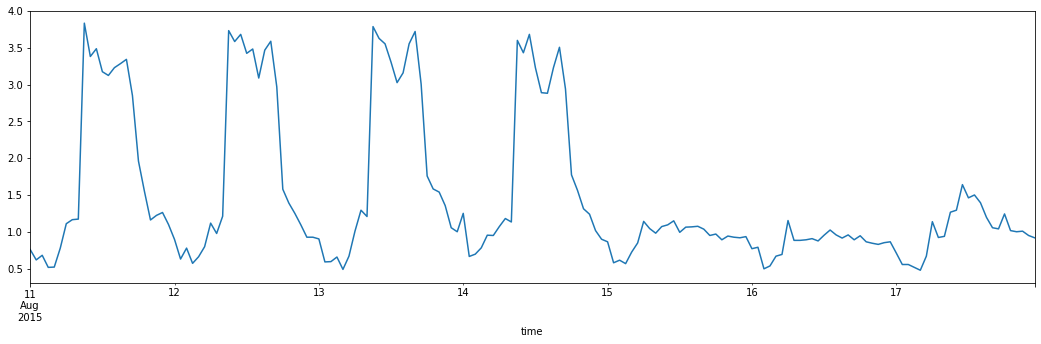

In [25]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [26]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [27]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [28]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [29]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063462
0:	learn: 1.9021190	total: 56.4ms	remaining: 56.3s
1:	learn: 1.8126397	total: 58.8ms	remaining: 29.4s
2:	learn: 1.7295371	total: 61.1ms	remaining: 20.3s
3:	learn: 1.6531055	total: 63.2ms	remaining: 15.7s
4:	learn: 1.5829596	total: 65.3ms	remaining: 13s
5:	learn: 1.5172177	total: 67.4ms	remaining: 11.2s
6:	learn: 1.4583006	total: 69.6ms	remaining: 9.87s
7:	learn: 1.4022904	total: 71.7ms	remaining: 8.89s
8:	learn: 1.3519502	total: 73.9ms	remaining: 8.13s
9:	learn: 1.3051437	total: 75.9ms	remaining: 7.52s
10:	learn: 1.2625295	total: 78.1ms	remaining: 7.02s
11:	learn: 1.2236371	total: 80.3ms	remaining: 6.61s
12:	learn: 1.1882331	total: 82.6ms	remaining: 6.27s
13:	learn: 1.1562660	total: 84.7ms	remaining: 5.97s
14:	learn: 1.1265692	total: 86.9ms	remaining: 5.71s
15:	learn: 1.0996298	total: 89.1ms	remaining: 5.48s
16:	learn: 1.0749785	total: 91.2ms	remaining: 5.27s
17:	learn: 1.0521629	total: 93.4ms	remaining: 5.1s
18:	learn: 1.0322155	total: 95.7ms	remaining: 4

240:	learn: 0.5629002	total: 541ms	remaining: 1.7s
241:	learn: 0.5624925	total: 543ms	remaining: 1.7s
242:	learn: 0.5619308	total: 545ms	remaining: 1.7s
243:	learn: 0.5616243	total: 547ms	remaining: 1.7s
244:	learn: 0.5611233	total: 549ms	remaining: 1.69s
245:	learn: 0.5608763	total: 551ms	remaining: 1.69s
246:	learn: 0.5604313	total: 554ms	remaining: 1.69s
247:	learn: 0.5599419	total: 556ms	remaining: 1.69s
248:	learn: 0.5593347	total: 558ms	remaining: 1.68s
249:	learn: 0.5589518	total: 560ms	remaining: 1.68s
250:	learn: 0.5583143	total: 562ms	remaining: 1.68s
251:	learn: 0.5576411	total: 564ms	remaining: 1.67s
252:	learn: 0.5571772	total: 566ms	remaining: 1.67s
253:	learn: 0.5568519	total: 568ms	remaining: 1.67s
254:	learn: 0.5565939	total: 570ms	remaining: 1.67s
255:	learn: 0.5562737	total: 572ms	remaining: 1.66s
256:	learn: 0.5558486	total: 574ms	remaining: 1.66s
257:	learn: 0.5551808	total: 576ms	remaining: 1.66s
258:	learn: 0.5546323	total: 578ms	remaining: 1.65s
259:	learn: 0.55

419:	learn: 0.5001857	total: 901ms	remaining: 1.24s
420:	learn: 0.4999300	total: 903ms	remaining: 1.24s
421:	learn: 0.4995445	total: 905ms	remaining: 1.24s
422:	learn: 0.4993532	total: 907ms	remaining: 1.24s
423:	learn: 0.4991705	total: 909ms	remaining: 1.23s
424:	learn: 0.4988751	total: 911ms	remaining: 1.23s
425:	learn: 0.4986054	total: 913ms	remaining: 1.23s
426:	learn: 0.4983152	total: 916ms	remaining: 1.23s
427:	learn: 0.4981599	total: 918ms	remaining: 1.23s
428:	learn: 0.4979026	total: 920ms	remaining: 1.22s
429:	learn: 0.4976707	total: 922ms	remaining: 1.22s
430:	learn: 0.4970905	total: 924ms	remaining: 1.22s
431:	learn: 0.4967608	total: 926ms	remaining: 1.22s
432:	learn: 0.4965132	total: 928ms	remaining: 1.22s
433:	learn: 0.4961423	total: 930ms	remaining: 1.21s
434:	learn: 0.4959395	total: 932ms	remaining: 1.21s
435:	learn: 0.4957520	total: 934ms	remaining: 1.21s
436:	learn: 0.4954732	total: 936ms	remaining: 1.21s
437:	learn: 0.4953328	total: 938ms	remaining: 1.2s
438:	learn: 0

588:	learn: 0.4656509	total: 1.26s	remaining: 877ms
589:	learn: 0.4655798	total: 1.26s	remaining: 875ms
590:	learn: 0.4654940	total: 1.26s	remaining: 873ms
591:	learn: 0.4653327	total: 1.26s	remaining: 871ms
592:	learn: 0.4651482	total: 1.26s	remaining: 868ms
593:	learn: 0.4650303	total: 1.27s	remaining: 866ms
594:	learn: 0.4649081	total: 1.27s	remaining: 864ms
595:	learn: 0.4646686	total: 1.27s	remaining: 862ms
596:	learn: 0.4645291	total: 1.27s	remaining: 860ms
597:	learn: 0.4643617	total: 1.27s	remaining: 858ms
598:	learn: 0.4641742	total: 1.28s	remaining: 856ms
599:	learn: 0.4640487	total: 1.28s	remaining: 853ms
600:	learn: 0.4639135	total: 1.28s	remaining: 851ms
601:	learn: 0.4637746	total: 1.28s	remaining: 849ms
602:	learn: 0.4636440	total: 1.29s	remaining: 847ms
603:	learn: 0.4634417	total: 1.29s	remaining: 845ms
604:	learn: 0.4632470	total: 1.29s	remaining: 842ms
605:	learn: 0.4629989	total: 1.29s	remaining: 840ms
606:	learn: 0.4628884	total: 1.29s	remaining: 838ms
607:	learn: 

767:	learn: 0.4391018	total: 1.62s	remaining: 489ms
768:	learn: 0.4388805	total: 1.62s	remaining: 487ms
769:	learn: 0.4387554	total: 1.62s	remaining: 485ms
770:	learn: 0.4386482	total: 1.62s	remaining: 482ms
771:	learn: 0.4385294	total: 1.63s	remaining: 480ms
772:	learn: 0.4384008	total: 1.63s	remaining: 478ms
773:	learn: 0.4383248	total: 1.63s	remaining: 476ms
774:	learn: 0.4381637	total: 1.63s	remaining: 474ms
775:	learn: 0.4380045	total: 1.63s	remaining: 472ms
776:	learn: 0.4379404	total: 1.64s	remaining: 470ms
777:	learn: 0.4377819	total: 1.64s	remaining: 468ms
778:	learn: 0.4376528	total: 1.64s	remaining: 465ms
779:	learn: 0.4374896	total: 1.64s	remaining: 463ms
780:	learn: 0.4374364	total: 1.64s	remaining: 461ms
781:	learn: 0.4372876	total: 1.65s	remaining: 459ms
782:	learn: 0.4371832	total: 1.65s	remaining: 457ms
783:	learn: 0.4371046	total: 1.65s	remaining: 455ms
784:	learn: 0.4369063	total: 1.65s	remaining: 453ms
785:	learn: 0.4367747	total: 1.65s	remaining: 451ms
786:	learn: 

948:	learn: 0.4185469	total: 1.98s	remaining: 106ms
949:	learn: 0.4184841	total: 1.98s	remaining: 104ms
950:	learn: 0.4183504	total: 1.98s	remaining: 102ms
951:	learn: 0.4182592	total: 1.98s	remaining: 100ms
952:	learn: 0.4181239	total: 1.99s	remaining: 98ms
953:	learn: 0.4180710	total: 1.99s	remaining: 95.9ms
954:	learn: 0.4179532	total: 1.99s	remaining: 93.8ms
955:	learn: 0.4178072	total: 1.99s	remaining: 91.7ms
956:	learn: 0.4176505	total: 1.99s	remaining: 89.6ms
957:	learn: 0.4175200	total: 2s	remaining: 87.5ms
958:	learn: 0.4174270	total: 2s	remaining: 85.5ms
959:	learn: 0.4173589	total: 2s	remaining: 83.4ms
960:	learn: 0.4172878	total: 2s	remaining: 81.3ms
961:	learn: 0.4171908	total: 2s	remaining: 79.2ms
962:	learn: 0.4171277	total: 2.01s	remaining: 77.1ms
963:	learn: 0.4170583	total: 2.01s	remaining: 75ms
964:	learn: 0.4169771	total: 2.01s	remaining: 72.9ms
965:	learn: 0.4168290	total: 2.01s	remaining: 70.8ms
966:	learn: 0.4167128	total: 2.01s	remaining: 68.8ms
967:	learn: 0.41

<h5>构建xgboost</h5>

In [30]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [31]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [32]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-26 11:05:05,797 [INFO] loading LSTM model from ../models/LSTM_socket_final.h5


In [33]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

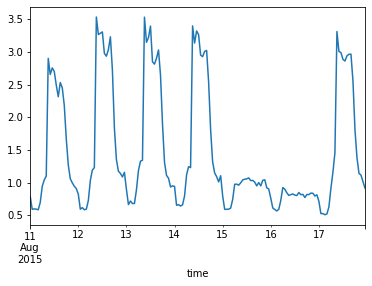

In [34]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

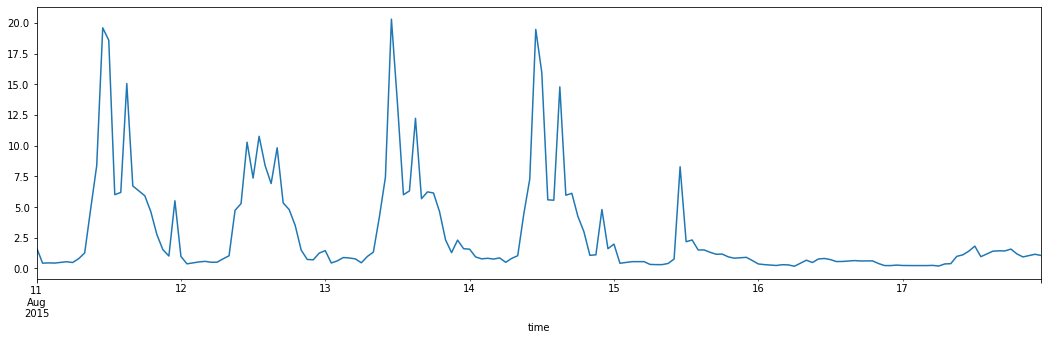

In [35]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [36]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [37]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [38]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [39]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063462
0:	learn: 3.5540881	total: 2.58ms	remaining: 2.58s
1:	learn: 3.3893379	total: 5.1ms	remaining: 2.54s
2:	learn: 3.2378582	total: 7.64ms	remaining: 2.54s
3:	learn: 3.0988288	total: 10.1ms	remaining: 2.51s
4:	learn: 2.9714656	total: 12.5ms	remaining: 2.48s
5:	learn: 2.8552029	total: 14.9ms	remaining: 2.46s
6:	learn: 2.7462927	total: 17.2ms	remaining: 2.44s
7:	learn: 2.6491827	total: 19.4ms	remaining: 2.41s
8:	learn: 2.5585888	total: 21.7ms	remaining: 2.39s
9:	learn: 2.4750524	total: 24.1ms	remaining: 2.38s
10:	learn: 2.3994791	total: 26.3ms	remaining: 2.36s
11:	learn: 2.3320206	total: 28.5ms	remaining: 2.35s
12:	learn: 2.2687804	total: 30.8ms	remaining: 2.33s
13:	learn: 2.2078399	total: 33ms	remaining: 2.33s
14:	learn: 2.1514234	total: 35.3ms	remaining: 2.31s
15:	learn: 2.1065493	total: 37.5ms	remaining: 2.31s
16:	learn: 2.0580619	total: 39.8ms	remaining: 2.3s
17:	learn: 2.0164637	total: 42ms	remaining: 2.29s
18:	learn: 1.9787386	total: 44.4ms	remaining: 2.29

168:	learn: 1.3557097	total: 347ms	remaining: 1.7s
169:	learn: 1.3543783	total: 349ms	remaining: 1.7s
170:	learn: 1.3527879	total: 351ms	remaining: 1.7s
171:	learn: 1.3516366	total: 353ms	remaining: 1.7s
172:	learn: 1.3502194	total: 355ms	remaining: 1.7s
173:	learn: 1.3496510	total: 357ms	remaining: 1.69s
174:	learn: 1.3486192	total: 359ms	remaining: 1.69s
175:	learn: 1.3479762	total: 361ms	remaining: 1.69s
176:	learn: 1.3471821	total: 363ms	remaining: 1.69s
177:	learn: 1.3453380	total: 365ms	remaining: 1.69s
178:	learn: 1.3444545	total: 367ms	remaining: 1.68s
179:	learn: 1.3433610	total: 369ms	remaining: 1.68s
180:	learn: 1.3421668	total: 371ms	remaining: 1.68s
181:	learn: 1.3406356	total: 373ms	remaining: 1.68s
182:	learn: 1.3398626	total: 375ms	remaining: 1.67s
183:	learn: 1.3390635	total: 377ms	remaining: 1.67s
184:	learn: 1.3382592	total: 379ms	remaining: 1.67s
185:	learn: 1.3374828	total: 381ms	remaining: 1.67s
186:	learn: 1.3355243	total: 383ms	remaining: 1.66s
187:	learn: 1.334

355:	learn: 1.2089868	total: 708ms	remaining: 1.28s
356:	learn: 1.2081382	total: 710ms	remaining: 1.28s
357:	learn: 1.2077026	total: 712ms	remaining: 1.28s
358:	learn: 1.2071768	total: 714ms	remaining: 1.27s
359:	learn: 1.2066787	total: 716ms	remaining: 1.27s
360:	learn: 1.2062125	total: 718ms	remaining: 1.27s
361:	learn: 1.2057119	total: 720ms	remaining: 1.27s
362:	learn: 1.2053082	total: 722ms	remaining: 1.27s
363:	learn: 1.2048835	total: 724ms	remaining: 1.26s
364:	learn: 1.2042859	total: 726ms	remaining: 1.26s
365:	learn: 1.2036310	total: 728ms	remaining: 1.26s
366:	learn: 1.2031592	total: 730ms	remaining: 1.26s
367:	learn: 1.2023379	total: 732ms	remaining: 1.26s
368:	learn: 1.2017816	total: 734ms	remaining: 1.25s
369:	learn: 1.2010935	total: 736ms	remaining: 1.25s
370:	learn: 1.2006388	total: 738ms	remaining: 1.25s
371:	learn: 1.1999853	total: 740ms	remaining: 1.25s
372:	learn: 1.1994737	total: 742ms	remaining: 1.25s
373:	learn: 1.1990807	total: 743ms	remaining: 1.24s
374:	learn: 

542:	learn: 1.1256339	total: 1.07s	remaining: 900ms
543:	learn: 1.1252651	total: 1.07s	remaining: 898ms
544:	learn: 1.1241226	total: 1.07s	remaining: 896ms
545:	learn: 1.1238842	total: 1.07s	remaining: 894ms
546:	learn: 1.1235264	total: 1.08s	remaining: 892ms
547:	learn: 1.1232680	total: 1.08s	remaining: 890ms
548:	learn: 1.1230034	total: 1.08s	remaining: 888ms
549:	learn: 1.1228011	total: 1.08s	remaining: 886ms
550:	learn: 1.1221860	total: 1.08s	remaining: 885ms
551:	learn: 1.1214825	total: 1.09s	remaining: 883ms
552:	learn: 1.1211678	total: 1.09s	remaining: 881ms
553:	learn: 1.1207582	total: 1.09s	remaining: 879ms
554:	learn: 1.1205168	total: 1.09s	remaining: 877ms
555:	learn: 1.1195646	total: 1.09s	remaining: 875ms
556:	learn: 1.1191252	total: 1.1s	remaining: 873ms
557:	learn: 1.1187252	total: 1.1s	remaining: 871ms
558:	learn: 1.1183599	total: 1.1s	remaining: 869ms
559:	learn: 1.1178465	total: 1.1s	remaining: 866ms
560:	learn: 1.1173805	total: 1.1s	remaining: 864ms
561:	learn: 1.116

729:	learn: 1.0573053	total: 1.43s	remaining: 529ms
730:	learn: 1.0569854	total: 1.43s	remaining: 527ms
731:	learn: 1.0566135	total: 1.43s	remaining: 525ms
732:	learn: 1.0564435	total: 1.44s	remaining: 523ms
733:	learn: 1.0560100	total: 1.44s	remaining: 522ms
734:	learn: 1.0556694	total: 1.44s	remaining: 520ms
735:	learn: 1.0552075	total: 1.45s	remaining: 519ms
736:	learn: 1.0548272	total: 1.45s	remaining: 517ms
737:	learn: 1.0544816	total: 1.45s	remaining: 515ms
738:	learn: 1.0542943	total: 1.45s	remaining: 513ms
739:	learn: 1.0540130	total: 1.46s	remaining: 511ms
740:	learn: 1.0535657	total: 1.46s	remaining: 509ms
741:	learn: 1.0533647	total: 1.46s	remaining: 507ms
742:	learn: 1.0531111	total: 1.46s	remaining: 505ms
743:	learn: 1.0526747	total: 1.46s	remaining: 503ms
744:	learn: 1.0525143	total: 1.47s	remaining: 501ms
745:	learn: 1.0520262	total: 1.47s	remaining: 499ms
746:	learn: 1.0517684	total: 1.47s	remaining: 497ms
747:	learn: 1.0511426	total: 1.47s	remaining: 495ms
748:	learn: 

914:	learn: 1.0056455	total: 1.79s	remaining: 166ms
915:	learn: 1.0054081	total: 1.79s	remaining: 165ms
916:	learn: 1.0051332	total: 1.8s	remaining: 163ms
917:	learn: 1.0050364	total: 1.8s	remaining: 161ms
918:	learn: 1.0047531	total: 1.8s	remaining: 159ms
919:	learn: 1.0046206	total: 1.8s	remaining: 157ms
920:	learn: 1.0043170	total: 1.8s	remaining: 155ms
921:	learn: 1.0040336	total: 1.81s	remaining: 153ms
922:	learn: 1.0036910	total: 1.81s	remaining: 151ms
923:	learn: 1.0035192	total: 1.81s	remaining: 149ms
924:	learn: 1.0033234	total: 1.81s	remaining: 147ms
925:	learn: 1.0028074	total: 1.81s	remaining: 145ms
926:	learn: 1.0026817	total: 1.82s	remaining: 143ms
927:	learn: 1.0024872	total: 1.82s	remaining: 141ms
928:	learn: 1.0023571	total: 1.82s	remaining: 139ms
929:	learn: 1.0021485	total: 1.82s	remaining: 137ms
930:	learn: 1.0017835	total: 1.82s	remaining: 135ms
931:	learn: 1.0015737	total: 1.83s	remaining: 133ms
932:	learn: 1.0013942	total: 1.83s	remaining: 131ms
933:	learn: 1.001

<h5>构建xgboost</h5>

In [40]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [41]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

In [42]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-26 11:05:13,149 [INFO] loading LSTM model from ../models/LSTM_light_final.h5


In [43]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

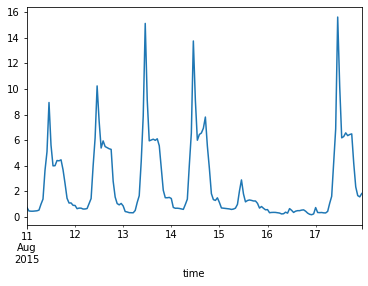

In [44]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

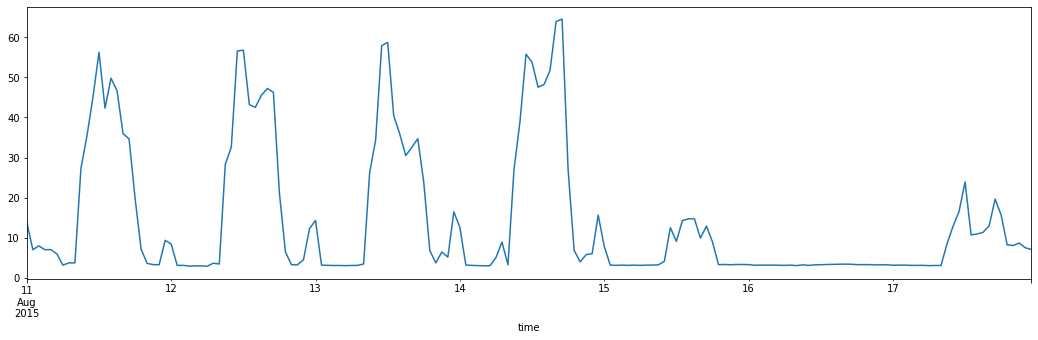

In [45]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [46]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [47]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [48]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [49]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063462
0:	learn: 14.1219252	total: 2.84ms	remaining: 2.83s
1:	learn: 13.5629992	total: 5.44ms	remaining: 2.71s
2:	learn: 13.0535653	total: 8ms	remaining: 2.66s
3:	learn: 12.5761175	total: 10.4ms	remaining: 2.58s
4:	learn: 12.1192898	total: 12.9ms	remaining: 2.57s
5:	learn: 11.7115226	total: 15.4ms	remaining: 2.55s
6:	learn: 11.3453532	total: 17.8ms	remaining: 2.53s
7:	learn: 11.0140004	total: 20.4ms	remaining: 2.53s
8:	learn: 10.6898685	total: 22.8ms	remaining: 2.51s
9:	learn: 10.3979704	total: 25.4ms	remaining: 2.52s
10:	learn: 10.1300857	total: 27.9ms	remaining: 2.51s
11:	learn: 9.8844832	total: 30.4ms	remaining: 2.5s
12:	learn: 9.6610335	total: 32.9ms	remaining: 2.5s
13:	learn: 9.4508369	total: 35.4ms	remaining: 2.49s
14:	learn: 9.2570145	total: 37.8ms	remaining: 2.48s
15:	learn: 9.0886974	total: 40.3ms	remaining: 2.48s
16:	learn: 8.9277281	total: 42.7ms	remaining: 2.47s
17:	learn: 8.7845241	total: 45.1ms	remaining: 2.46s
18:	learn: 8.6553853	total: 47.6ms	rem

159:	learn: 5.2620948	total: 346ms	remaining: 1.81s
160:	learn: 5.2581994	total: 348ms	remaining: 1.81s
161:	learn: 5.2496560	total: 350ms	remaining: 1.81s
162:	learn: 5.2448700	total: 352ms	remaining: 1.81s
163:	learn: 5.2369183	total: 354ms	remaining: 1.8s
164:	learn: 5.2296344	total: 356ms	remaining: 1.8s
165:	learn: 5.2225434	total: 358ms	remaining: 1.8s
166:	learn: 5.2161037	total: 361ms	remaining: 1.8s
167:	learn: 5.2078253	total: 364ms	remaining: 1.8s
168:	learn: 5.2009720	total: 366ms	remaining: 1.8s
169:	learn: 5.1948162	total: 368ms	remaining: 1.8s
170:	learn: 5.1884364	total: 371ms	remaining: 1.8s
171:	learn: 5.1830285	total: 373ms	remaining: 1.79s
172:	learn: 5.1755317	total: 375ms	remaining: 1.79s
173:	learn: 5.1680977	total: 377ms	remaining: 1.79s
174:	learn: 5.1622114	total: 379ms	remaining: 1.79s
175:	learn: 5.1543891	total: 381ms	remaining: 1.78s
176:	learn: 5.1481445	total: 383ms	remaining: 1.78s
177:	learn: 5.1420197	total: 385ms	remaining: 1.78s
178:	learn: 5.136234

334:	learn: 4.3410505	total: 707ms	remaining: 1.4s
335:	learn: 4.3389169	total: 709ms	remaining: 1.4s
336:	learn: 4.3337823	total: 711ms	remaining: 1.4s
337:	learn: 4.3302785	total: 713ms	remaining: 1.4s
338:	learn: 4.3282794	total: 715ms	remaining: 1.39s
339:	learn: 4.3243990	total: 718ms	remaining: 1.39s
340:	learn: 4.3200320	total: 720ms	remaining: 1.39s
341:	learn: 4.3172040	total: 722ms	remaining: 1.39s
342:	learn: 4.3141845	total: 725ms	remaining: 1.39s
343:	learn: 4.3109705	total: 727ms	remaining: 1.39s
344:	learn: 4.3070845	total: 729ms	remaining: 1.38s
345:	learn: 4.3019929	total: 731ms	remaining: 1.38s
346:	learn: 4.2982587	total: 733ms	remaining: 1.38s
347:	learn: 4.2949507	total: 735ms	remaining: 1.38s
348:	learn: 4.2916092	total: 737ms	remaining: 1.37s
349:	learn: 4.2865438	total: 739ms	remaining: 1.37s
350:	learn: 4.2834616	total: 741ms	remaining: 1.37s
351:	learn: 4.2784958	total: 743ms	remaining: 1.37s
352:	learn: 4.2749831	total: 745ms	remaining: 1.36s
353:	learn: 4.27

509:	learn: 3.8436898	total: 1.07s	remaining: 1.03s
510:	learn: 3.8414722	total: 1.07s	remaining: 1.02s
511:	learn: 3.8388447	total: 1.07s	remaining: 1.02s
512:	learn: 3.8370043	total: 1.07s	remaining: 1.02s
513:	learn: 3.8338508	total: 1.08s	remaining: 1.02s
514:	learn: 3.8318030	total: 1.08s	remaining: 1.02s
515:	learn: 3.8303758	total: 1.08s	remaining: 1.01s
516:	learn: 3.8291230	total: 1.08s	remaining: 1.01s
517:	learn: 3.8268822	total: 1.09s	remaining: 1.01s
518:	learn: 3.8248373	total: 1.09s	remaining: 1.01s
519:	learn: 3.8229594	total: 1.09s	remaining: 1.01s
520:	learn: 3.8215177	total: 1.09s	remaining: 1s
521:	learn: 3.8191604	total: 1.09s	remaining: 1s
522:	learn: 3.8173497	total: 1.1s	remaining: 1s
523:	learn: 3.8157086	total: 1.1s	remaining: 999ms
524:	learn: 3.8141330	total: 1.1s	remaining: 997ms
525:	learn: 3.8122100	total: 1.1s	remaining: 995ms
526:	learn: 3.8103369	total: 1.11s	remaining: 993ms
527:	learn: 3.8079720	total: 1.11s	remaining: 991ms
528:	learn: 3.8066827	tot

683:	learn: 3.5293839	total: 1.43s	remaining: 661ms
684:	learn: 3.5287732	total: 1.43s	remaining: 659ms
685:	learn: 3.5261890	total: 1.43s	remaining: 657ms
686:	learn: 3.5248572	total: 1.44s	remaining: 654ms
687:	learn: 3.5215965	total: 1.44s	remaining: 652ms
688:	learn: 3.5192714	total: 1.44s	remaining: 650ms
689:	learn: 3.5182368	total: 1.44s	remaining: 648ms
690:	learn: 3.5163470	total: 1.45s	remaining: 646ms
691:	learn: 3.5151025	total: 1.45s	remaining: 644ms
692:	learn: 3.5139388	total: 1.45s	remaining: 642ms
693:	learn: 3.5122915	total: 1.45s	remaining: 640ms
694:	learn: 3.5109964	total: 1.45s	remaining: 638ms
695:	learn: 3.5097719	total: 1.46s	remaining: 636ms
696:	learn: 3.5084452	total: 1.46s	remaining: 634ms
697:	learn: 3.5072048	total: 1.46s	remaining: 632ms
698:	learn: 3.5058383	total: 1.46s	remaining: 630ms
699:	learn: 3.5044308	total: 1.46s	remaining: 627ms
700:	learn: 3.5023383	total: 1.47s	remaining: 625ms
701:	learn: 3.5010202	total: 1.47s	remaining: 623ms
702:	learn: 

858:	learn: 3.2996356	total: 1.79s	remaining: 294ms
859:	learn: 3.2978221	total: 1.79s	remaining: 292ms
860:	learn: 3.2967631	total: 1.79s	remaining: 290ms
861:	learn: 3.2956485	total: 1.8s	remaining: 288ms
862:	learn: 3.2932629	total: 1.8s	remaining: 286ms
863:	learn: 3.2922999	total: 1.8s	remaining: 284ms
864:	learn: 3.2914486	total: 1.8s	remaining: 282ms
865:	learn: 3.2901209	total: 1.81s	remaining: 279ms
866:	learn: 3.2890165	total: 1.81s	remaining: 277ms
867:	learn: 3.2874928	total: 1.81s	remaining: 275ms
868:	learn: 3.2864799	total: 1.81s	remaining: 273ms
869:	learn: 3.2852522	total: 1.81s	remaining: 271ms
870:	learn: 3.2844374	total: 1.82s	remaining: 269ms
871:	learn: 3.2827141	total: 1.82s	remaining: 267ms
872:	learn: 3.2817990	total: 1.82s	remaining: 265ms
873:	learn: 3.2810316	total: 1.82s	remaining: 263ms
874:	learn: 3.2797090	total: 1.82s	remaining: 261ms
875:	learn: 3.2788177	total: 1.83s	remaining: 259ms
876:	learn: 3.2780185	total: 1.83s	remaining: 256ms
877:	learn: 3.27

<h5>构建xgboost</h5>

In [50]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [51]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [52]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-26 11:05:19,881 [INFO] loading LSTM model from ../models/LSTM_air_final.h5


In [53]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

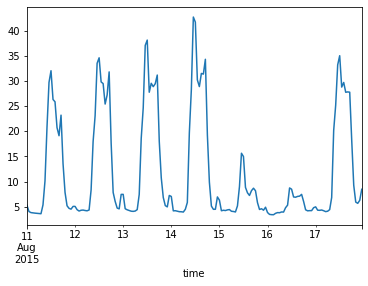

In [54]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

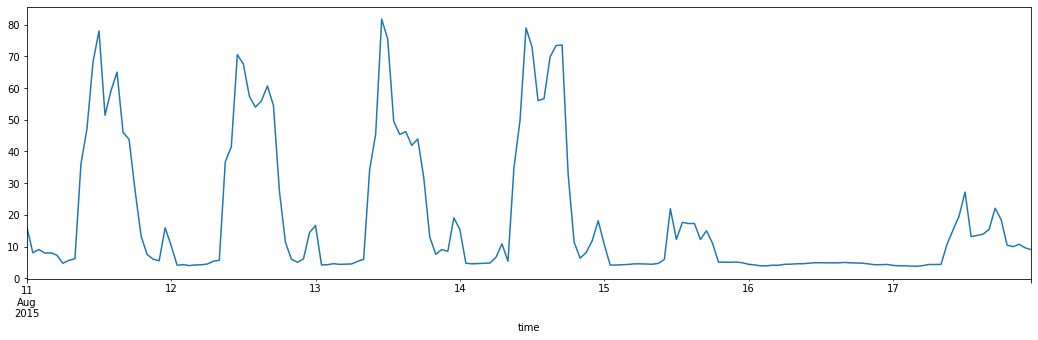

In [55]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [56]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [57]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [58]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [59]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063462
0:	learn: 17.9541345	total: 3.18ms	remaining: 3.18s
1:	learn: 17.1668572	total: 5.82ms	remaining: 2.9s
2:	learn: 16.4419627	total: 8.43ms	remaining: 2.8s
3:	learn: 15.7720381	total: 10.9ms	remaining: 2.72s
4:	learn: 15.1575358	total: 13.4ms	remaining: 2.67s
5:	learn: 14.5964288	total: 16ms	remaining: 2.65s
6:	learn: 14.0740599	total: 18.5ms	remaining: 2.62s
7:	learn: 13.6070939	total: 21ms	remaining: 2.61s
8:	learn: 13.1636066	total: 23.5ms	remaining: 2.59s
9:	learn: 12.7600513	total: 25.9ms	remaining: 2.57s
10:	learn: 12.3902980	total: 28.4ms	remaining: 2.55s
11:	learn: 12.0467787	total: 31ms	remaining: 2.55s
12:	learn: 11.7297732	total: 33.5ms	remaining: 2.54s
13:	learn: 11.4498431	total: 36ms	remaining: 2.54s
14:	learn: 11.1953412	total: 38.5ms	remaining: 2.53s
15:	learn: 10.9662390	total: 41ms	remaining: 2.52s
16:	learn: 10.7478710	total: 43.4ms	remaining: 2.51s
17:	learn: 10.5461848	total: 45.9ms	remaining: 2.5s
18:	learn: 10.3652576	total: 48.3ms	rem

162:	learn: 5.9645133	total: 356ms	remaining: 1.83s
163:	learn: 5.9533993	total: 358ms	remaining: 1.82s
164:	learn: 5.9432924	total: 360ms	remaining: 1.82s
165:	learn: 5.9364711	total: 362ms	remaining: 1.82s
166:	learn: 5.9274089	total: 364ms	remaining: 1.82s
167:	learn: 5.9170521	total: 366ms	remaining: 1.81s
168:	learn: 5.9047575	total: 369ms	remaining: 1.81s
169:	learn: 5.8967634	total: 371ms	remaining: 1.81s
170:	learn: 5.8837689	total: 373ms	remaining: 1.81s
171:	learn: 5.8764073	total: 376ms	remaining: 1.81s
172:	learn: 5.8685295	total: 378ms	remaining: 1.81s
173:	learn: 5.8609182	total: 380ms	remaining: 1.8s
174:	learn: 5.8533551	total: 383ms	remaining: 1.8s
175:	learn: 5.8465078	total: 385ms	remaining: 1.8s
176:	learn: 5.8377399	total: 387ms	remaining: 1.8s
177:	learn: 5.8285305	total: 389ms	remaining: 1.8s
178:	learn: 5.8227283	total: 391ms	remaining: 1.79s
179:	learn: 5.8128747	total: 393ms	remaining: 1.79s
180:	learn: 5.8055884	total: 395ms	remaining: 1.79s
181:	learn: 5.790

335:	learn: 4.9233167	total: 717ms	remaining: 1.42s
336:	learn: 4.9185151	total: 719ms	remaining: 1.42s
337:	learn: 4.9155392	total: 722ms	remaining: 1.41s
338:	learn: 4.9131874	total: 724ms	remaining: 1.41s
339:	learn: 4.9107416	total: 726ms	remaining: 1.41s
340:	learn: 4.9055993	total: 728ms	remaining: 1.41s
341:	learn: 4.9025675	total: 731ms	remaining: 1.41s
342:	learn: 4.8987629	total: 733ms	remaining: 1.4s
343:	learn: 4.8963931	total: 735ms	remaining: 1.4s
344:	learn: 4.8942475	total: 737ms	remaining: 1.4s
345:	learn: 4.8900508	total: 739ms	remaining: 1.4s
346:	learn: 4.8844033	total: 741ms	remaining: 1.39s
347:	learn: 4.8808906	total: 743ms	remaining: 1.39s
348:	learn: 4.8760089	total: 745ms	remaining: 1.39s
349:	learn: 4.8713447	total: 748ms	remaining: 1.39s
350:	learn: 4.8642206	total: 750ms	remaining: 1.39s
351:	learn: 4.8559748	total: 752ms	remaining: 1.38s
352:	learn: 4.8527527	total: 754ms	remaining: 1.38s
353:	learn: 4.8493461	total: 756ms	remaining: 1.38s
354:	learn: 4.84

508:	learn: 4.3831376	total: 1.08s	remaining: 1.04s
509:	learn: 4.3814971	total: 1.08s	remaining: 1.04s
510:	learn: 4.3787628	total: 1.08s	remaining: 1.04s
511:	learn: 4.3773617	total: 1.09s	remaining: 1.03s
512:	learn: 4.3750644	total: 1.09s	remaining: 1.03s
513:	learn: 4.3720280	total: 1.09s	remaining: 1.03s
514:	learn: 4.3685475	total: 1.09s	remaining: 1.03s
515:	learn: 4.3668751	total: 1.09s	remaining: 1.03s
516:	learn: 4.3656159	total: 1.1s	remaining: 1.02s
517:	learn: 4.3627065	total: 1.1s	remaining: 1.02s
518:	learn: 4.3615848	total: 1.1s	remaining: 1.02s
519:	learn: 4.3600736	total: 1.1s	remaining: 1.02s
520:	learn: 4.3581661	total: 1.1s	remaining: 1.01s
521:	learn: 4.3562661	total: 1.11s	remaining: 1.01s
522:	learn: 4.3534225	total: 1.11s	remaining: 1.01s
523:	learn: 4.3515959	total: 1.11s	remaining: 1.01s
524:	learn: 4.3494706	total: 1.11s	remaining: 1.01s
525:	learn: 4.3475476	total: 1.11s	remaining: 1s
526:	learn: 4.3457148	total: 1.12s	remaining: 1s
527:	learn: 4.3437983	t

681:	learn: 4.0251837	total: 1.44s	remaining: 672ms
682:	learn: 4.0229816	total: 1.44s	remaining: 670ms
683:	learn: 4.0206726	total: 1.44s	remaining: 667ms
684:	learn: 4.0194164	total: 1.45s	remaining: 665ms
685:	learn: 4.0183971	total: 1.45s	remaining: 663ms
686:	learn: 4.0170613	total: 1.45s	remaining: 661ms
687:	learn: 4.0139445	total: 1.45s	remaining: 659ms
688:	learn: 4.0124935	total: 1.46s	remaining: 657ms
689:	learn: 4.0109499	total: 1.46s	remaining: 655ms
690:	learn: 4.0081618	total: 1.46s	remaining: 653ms
691:	learn: 4.0057670	total: 1.46s	remaining: 651ms
692:	learn: 4.0036245	total: 1.46s	remaining: 649ms
693:	learn: 4.0023124	total: 1.47s	remaining: 646ms
694:	learn: 4.0010108	total: 1.47s	remaining: 644ms
695:	learn: 3.9989174	total: 1.47s	remaining: 642ms
696:	learn: 3.9976056	total: 1.47s	remaining: 640ms
697:	learn: 3.9968865	total: 1.47s	remaining: 638ms
698:	learn: 3.9946083	total: 1.48s	remaining: 636ms
699:	learn: 3.9937096	total: 1.48s	remaining: 634ms
700:	learn: 

855:	learn: 3.7546010	total: 1.8s	remaining: 303ms
856:	learn: 3.7531149	total: 1.8s	remaining: 301ms
857:	learn: 3.7521542	total: 1.8s	remaining: 299ms
858:	learn: 3.7506169	total: 1.81s	remaining: 297ms
859:	learn: 3.7488786	total: 1.81s	remaining: 295ms
860:	learn: 3.7479627	total: 1.81s	remaining: 292ms
861:	learn: 3.7468610	total: 1.81s	remaining: 290ms
862:	learn: 3.7454153	total: 1.81s	remaining: 288ms
863:	learn: 3.7447483	total: 1.82s	remaining: 286ms
864:	learn: 3.7439533	total: 1.82s	remaining: 284ms
865:	learn: 3.7417047	total: 1.82s	remaining: 282ms
866:	learn: 3.7407106	total: 1.82s	remaining: 280ms
867:	learn: 3.7398061	total: 1.82s	remaining: 278ms
868:	learn: 3.7385889	total: 1.83s	remaining: 276ms
869:	learn: 3.7376717	total: 1.83s	remaining: 273ms
870:	learn: 3.7366482	total: 1.83s	remaining: 271ms
871:	learn: 3.7349298	total: 1.83s	remaining: 269ms
872:	learn: 3.7338630	total: 1.84s	remaining: 267ms
873:	learn: 3.7320731	total: 1.84s	remaining: 265ms
874:	learn: 3.7

<h5>构建xgboost</h5>

In [60]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[11:05:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [61]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [62]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-26 11:05:26,539 [INFO] loading LSTM model from ../models/LSTM_total_final.h5


In [63]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

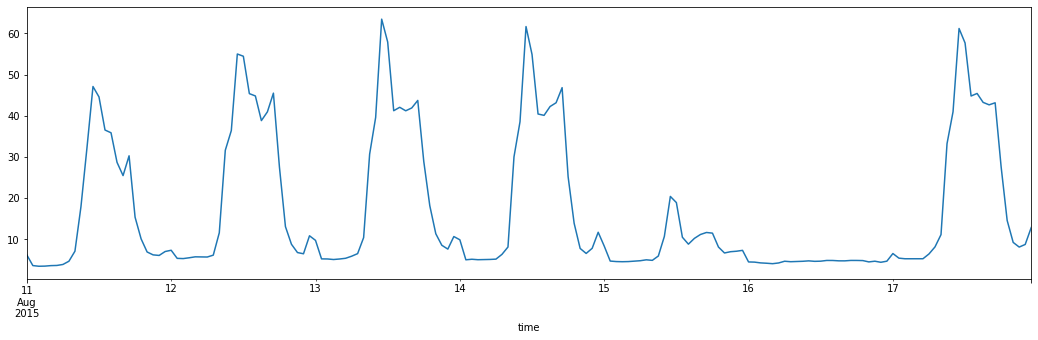

In [65]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4) / 4
total_pred[120:144] = total_pred2[120:144]
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [66]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,6.191188,0.789800,0.717274,5.314072
2015-08-11 01:00:00,3.598141,0.591017,0.447019,4.071452
2015-08-11 02:00:00,3.436061,0.597481,0.429454,3.856618
2015-08-11 03:00:00,3.467451,0.593692,0.429577,3.799284
2015-08-11 04:00:00,3.587124,0.584003,0.447141,3.751618
...,...,...,...,...
2015-08-17 19:00:00,14.556995,1.381153,4.184873,9.298140
2015-08-17 20:00:00,9.226263,1.141569,2.336463,5.947206
2015-08-17 21:00:00,8.093137,1.114039,1.650272,5.698709
2015-08-17 22:00:00,8.730544,1.016605,1.553413,6.296342


In [67]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)